In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_reader import read_consumption_and_weather, plot_consumption, plot_consumption_and_weather

In [142]:
df = read_consumption_and_weather()[-1]
df.head()

Holes by length and occurrences in column NO3:
holes
1        1
dtype: int64
Filling holes up to length 3
Any remaining holes after interpolation? False


mba                                NO1                     NO2              \
                           consumption temperature consumption temperature   
2017-05-01 00:00:00+00:00  3325.431995         2.2    3534.588    4.500000   
2017-05-01 01:00:00+00:00  3344.690998         3.2    3560.209    5.500000   
2017-05-01 02:00:00+00:00  3398.359002         4.0    3596.149    3.200000   
2017-05-01 03:00:00+00:00  3430.220001         3.6    3594.042    5.100000   
2017-05-01 04:00:00+00:00  3606.750000         3.4    3665.091    3.866667   

mba                               NO3                     NO4              \
                          consumption temperature consumption temperature   
2017-05-01 00:00:00+00:00    2674.838    5.250000    2061.209    0.150000   
2017-05-01 01:00:00+00:00    2678.188    4.000000    2045.436    0.050000   
2017-05-01 02:00:00+00:00    2678.341    3.350000    2020.007    0.150000   
2017-05-01 03:00:00+00:00    2684.172    3.066667    2021.920    0.100000   
2017-05-01 04:00:00+00:00    2733.345    2.933333    2045.913    0.866667   

mba                               NO5              
                          consumption temperature  
2017-05-01 00:00:00+00:00    1609.089         3.9  
2017-05-01 01:00:00+00:00    1623.485         3.2  
2017-05-01 02:00:00+00:00    1634.128         2.7  
2017-05-01 03:00:00+00:00    1647.906         2.4  
2017-05-01 04:00:00+00:00    1679.176         2.3

In [143]:
df.describe()

mba             NO1                         NO2                         NO3  \
        consumption   temperature   consumption   temperature   consumption   
count  50208.000000  50208.000000  50208.000000  50208.000000  50208.000000   
mean    3988.938389      7.929658   4169.734910      9.065414   3097.480634   
std     1311.064087      8.318640    713.038281      5.940013    479.545701   
min     1690.051994    -15.400000   2660.890000    -15.466667   1992.632558   
25%     2914.051405      1.433333   3596.381608      5.033333   2702.097259   
50%     3757.956266      7.800000   4062.967501      9.100000   3067.526689   
75%     4987.063169     14.400000   4699.310916     13.266667   3468.904199   
max     7928.670995     34.400000   6840.053130     32.000000   4756.004039   

mba                           NO4                         NO5                
        temperature   consumption   temperature   consumption   temperature  
count  50208.000000  50208.000000  50208.000000  50208.000000  50208.000000  
mean       6.796776   2178.804315      3.763234   1900.884893      9.053217  
std        7.819803    361.654375      6.652893    306.193275      6.173632  
min      -22.000000   1364.340713    -16.100000    989.346588    -11.500000  
25%        1.733333   1867.779176     -1.000000   1664.985942      4.500000  
50%        6.900000   2164.897660      3.800000   1887.130584      8.900000  
75%       12.200000   2474.167626      8.933333   2121.754746     13.325000  
max       33.933333   3097.133000     30.033333   2947.614289     32.300000

<AxesSubplot:xlabel='consumption', ylabel='Density'>

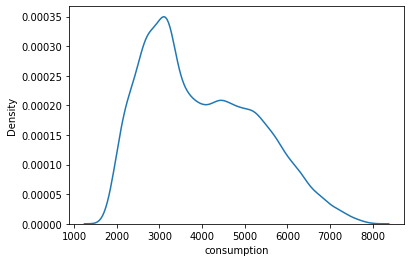

In [153]:
# violinplot the 5 different mba's
sns.kdeplot(data=df['NO1']['consumption'])

<AxesSubplot:xlabel='temperature', ylabel='Density'>

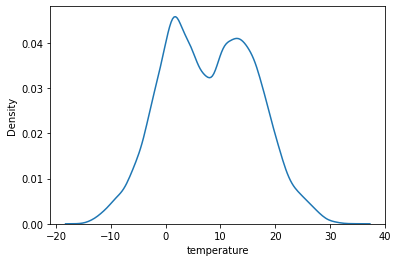

In [155]:
sns.kdeplot(data=df['NO1']['temperature'])